In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import h5py
import os 
import math 
from scipy.spatial import cKDTree
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [2]:
def list_files(directory: str, ftype):
    """
    List files all file in given folder.

    Parameters:
        directory (str): Directory to search for files.
        
    Returns:
        dict: A dictionary where keys are week ranges and values are lists of matching files.
    """
    matching_files = []
    matching_files.extend(
        [directory+"/"+f for f in os.listdir(directory) if f.endswith(ftype)]
    )
    #files_by_week[f"{start} to {stop}"] = matching_files

    return matching_files

# Function to generate the grid points
def generate_grid_points(top_left_lat, top_left_lon, bottom_right_lat, bottom_right_lon, grid_size):
    grid_points = []

    # Calculate the distance between the top-left and bottom-right corners
    lat_distance = abs(top_left_lat - bottom_right_lat)
    lon_distance = abs(top_left_lon - bottom_right_lon)

    # Calculate the number of grids in latitude and longitude directions
    num_lat_grids = int(lat_distance * 111.32 / grid_size)  # 1 degree latitude ~ 111.32 km
    num_lon_grids = int(lon_distance * 111.32 * math.cos(math.radians(top_left_lat)) / grid_size)

    # Generate grid points
    for i in range(num_lat_grids + 1):
        for j in range(num_lon_grids + 1):
            lat = top_left_lat - (i * grid_size / 111.32)
            lon = top_left_lon + (j * grid_size / (111.32 * math.cos(math.radians(top_left_lat))))
            grid_points.append((lat, lon))

    return grid_points

def load_combined_file(file_path):
    """
    Load the combined HDF5 file and extract the data.
    """
    print(file_path)
    with h5py.File(file_path, 'r') as f:
        soil_moisture = f['soil_moisture'][:]
        latitude = f['latitude'][:]
        longitude = f['longitude'][:]
    
    #print(soil_moisture)
    
    """
    plot_on_map(
        latitude,
        longitude,
        soil_moisture,
        [4.5, 25.5, 95.5, 110.5],
        #p_name,
        title=""
    )
    """
    return soil_moisture, latitude, longitude

def ReadData(csv_file, lat, lon):
    # Determine the bounding box of the SMAP data
    lat_min, lat_max = min(lat), max(lat)
    lon_min, lon_max = min(lon), max(lon)
    
    # Load telemetry station data (CSV format assumed)
    #tele_data = pd.read_csv(csv_file, names=['code','latitude','longitude','val'])
    tele_data = pd.read_csv(csv_file)
    #print(tele_data)
    
    # Filter telemetry stations within SMAP bounding box
    filtered_stations = tele_data[
        (tele_data['latitude'] >= lat_min) & (tele_data['latitude'] <= lat_max) &
        (tele_data['longitude'] >= lon_min) & (tele_data['longitude'] <= lon_max)
    ]
    return filtered_stations

def genSMAP(filtered_stations, smap_locations, _smapDf, paraName):
    tele_locations = filtered_stations[['latitude', 'longitude']].to_numpy()
    tele_values = filtered_stations['val'].to_numpy()
    
    #print(tele_locations, tele_values)
    
    smap_tree = cKDTree(smap_locations)
    
    # Keep track of used locations in smapDf
    used_smap_indices = set()
    
    # Prepare a column to store results
    _smapDf[paraName] = np.nan  # New column for matched SMAP values
    
    
    # Iterate over each smap location and match it to the nearest tele location
    for idx, tele_loc in enumerate(tele_locations):
        # Query the nearest tele location
        #distance, tele_idx = tele_tree.query(tele_loc)
        distance, smap_idx = smap_tree.query(tele_loc)
        #print(distance, smap_idx,idx , tele_loc, smap_locations[smap_idx])
    
        if smap_idx not in used_smap_indices:
            _smapDf.loc[smap_idx, paraName] = tele_values[idx]
            #print(distance, smap_idx,idx , tele_loc, smap_locations[smap_idx],tele_values[idx], smapDf['matched_smap_val'][idx])
            used_smap_indices.add(smap_idx)  # Mark this SMAP index as used
    
    #print(smapDf)
    return _smapDf

# IDW Interpolation function
def inverse_distance_weighting(x, y, values, xi, yi, power=2):
    tree = cKDTree(np.c_[x, y])
    distances, indices = tree.query(np.c_[xi.ravel(), yi.ravel()], k=5)
    weights = 1 / distances ** power
    weighted_values = np.sum(weights * values[indices], axis=1) / np.sum(weights, axis=1)
    return weighted_values.reshape(xi.shape)


In [3]:
# Constants
EARTH_RADIUS = 6371  # Earth's radius in kilometers
grid_size = 1

# NorthEast
lat_range = [18.607933, 14.012681]  # Define the latitude range of interest
lon_range = [101.005346, 105.995516]  # Define the longitude range of interest

# Top Left
#lat_range = [18.607933, 16.310307]  # Define the latitude range of interest
#lon_range = [101.005346, 103.5004]  # Define the longitude range of interest

# Bottom Left
#lat_range = [16.310307, 14.012681]  # Define the latitude range of interest
#lon_range = [101.005346, 103.5004]  # Define the longitude range of interest

# Top Right
#lat_range = [18.607933, 16.310307]  # Define the latitude range of interest
#lon_range = [103.5004, 105.995516]  # Define the longitude range of interest

# Bottom Right
#lat_range = [16.310307, 14.012681]  # Define the latitude range of interest
#lon_range = [103.5004, 105.995516]  # Define the longitude range of interest

# Calculate the distance in kilometers
#distance_left_2_right = geodesic((lat_range[0], lon_range[0]), (lat_range[0], lon_range[1])).kilometers
#distance_top_2_down = geodesic((lat_range[0], lon_range[0]), (lat_range[1], lon_range[0])).kilometers

#print(distance_left_2_right)
#print(distance_top_2_down)

grid_points = generate_grid_points(lat_range[0], lon_range[0], lat_range[1], lon_range[1], grid_size)

points = pd.DataFrame(grid_points, columns=['latitude', 'longitude'])
print(points)


         latitude   longitude
0       18.607933  101.005346
1       18.607933  101.014825
2       18.607933  101.024303
3       18.607933  101.033782
4       18.607933  101.043260
...           ...         ...
269819  14.017563  105.953182
269820  14.017563  105.962661
269821  14.017563  105.972139
269822  14.017563  105.981618
269823  14.017563  105.991097

[269824 rows x 2 columns]


In [6]:
# Paths to your data files
#smap_dir = "/Users/khaitao/Documents/GitHub/SMAP/Weekly/Thailand/"  # Replace with your .h5 file
smap_dir = "C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\"  # Replace with your .h5 file



In [7]:
h5_files = list_files(smap_dir,'.h5')
print(h5_files)


['C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-02to2023-01-08.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-09to2023-01-15.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-16to2023-01-22.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-23to2023-01-29.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-01-30to2023-02-05.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-06to2023-02-12.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-13to2023-02-19.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-20to2023-02-26.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-02-27to2023-03-05.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-06to2023-03-12.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-13to2023-03-19.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-20to2023-03-26.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-03-27to2023-04-02.h5', 'C:\\Work\\Github\\SMAP\\Weekly\\Thailand\\/2023-04-03to2023-04

In [8]:
# Build a KDTree for smapDf locations
smap_locations = points[['latitude', 'longitude']].to_numpy()
print(len(smap_locations))

lenLat = len(points['latitude'].unique())
lenLon = len(points['longitude'].unique())

# Create a grid for interpolation
lat_grid = np.linspace(points['latitude'].min(), points['latitude'].max(), lenLat)
lon_grid = np.linspace(points['longitude'].min(), points['longitude'].max(), lenLon)
grid_lat, grid_lon = np.meshgrid(lat_grid, lon_grid)

for combined_file in h5_files:
    #print(combined_file)
    soil_moisture, latitude, longitude = load_combined_file(combined_file)
    soil_moisture = np.ma.masked_invalid(soil_moisture)
    p_name = combined_file.replace(smap_dir+"/","")
    p_name = p_name.replace(".h5","")
    p_name = p_name[:10].replace("-","")
    #print(p_name)
    
    """
    humidDf= ReadData(tele_humid_dir+p_name+".csv", latitude, longitude)
    humidDf = humidDf.reset_index(drop=True)
    #print(humidDf)
    
    tempDf= ReadData(tele_temp_dir+p_name+".csv", latitude, longitude)
    tempDf = tempDf.reset_index(drop=True)
    #print(tempDf)
    
    rainDf= ReadData(tele_rain_dir+p_name+".csv", latitude, longitude)
    rainDf = rainDf.reset_index(drop=True)
    #print(rainDf)    
    """
    
    smapDf = pd.DataFrame(columns=['latitude','longitude','val'])
    smapDf['latitude'] = latitude
    smapDf['longitude'] = longitude
    smapDf['val'] = soil_moisture
    
    #print(smapDf[:10])
    
    smapDf = genSMAP(smapDf, smap_locations, points, "val")
    
    #print(len(humidDf['latitude']))
    #break
    """
    # Applying IDW to interpolate rain data on grid
    humid_idw = inverse_distance_weighting(
        humidDf['latitude'].values,
        humidDf['longitude'].values,
        humidDf['val'].values,
        grid_lat,
        grid_lon
    )
    """
    #smapDf['humid'] = humid_idw.reshape(1,-1)[0]
    break

269824
C:\Work\Github\SMAP\Weekly\Thailand\/2023-01-02to2023-01-08.h5


In [9]:
print(smapDf)


         latitude   longitude       val
0       18.607933  101.005346  0.480000
1       18.607933  101.014825  0.649764
2       18.607933  101.024303  0.020000
3       18.607933  101.033782  0.283000
4       18.607933  101.043260  0.046000
...           ...         ...       ...
269819  14.017563  105.953182  0.381000
269820  14.017563  105.962661  0.708679
269821  14.017563  105.972139  0.632170
269822  14.017563  105.981618  0.675283
269823  14.017563  105.991097  0.655333

[269824 rows x 3 columns]


In [10]:
# Apply KNN Imputer
knn_imputer = KNNImputer(n_neighbors=2, weights='uniform')
df_imputed = pd.DataFrame(knn_imputer.fit_transform(smapDf), columns=smapDf.columns)

print("\nImputed Data:")
print(df_imputed)



Imputed Data:
         latitude   longitude       val
0       18.607933  101.005346  0.480000
1       18.607933  101.014825  0.649764
2       18.607933  101.024303  0.020000
3       18.607933  101.033782  0.283000
4       18.607933  101.043260  0.046000
...           ...         ...       ...
269819  14.017563  105.953182  0.381000
269820  14.017563  105.962661  0.708679
269821  14.017563  105.972139  0.632170
269822  14.017563  105.981618  0.675283
269823  14.017563  105.991097  0.655333

[269824 rows x 3 columns]


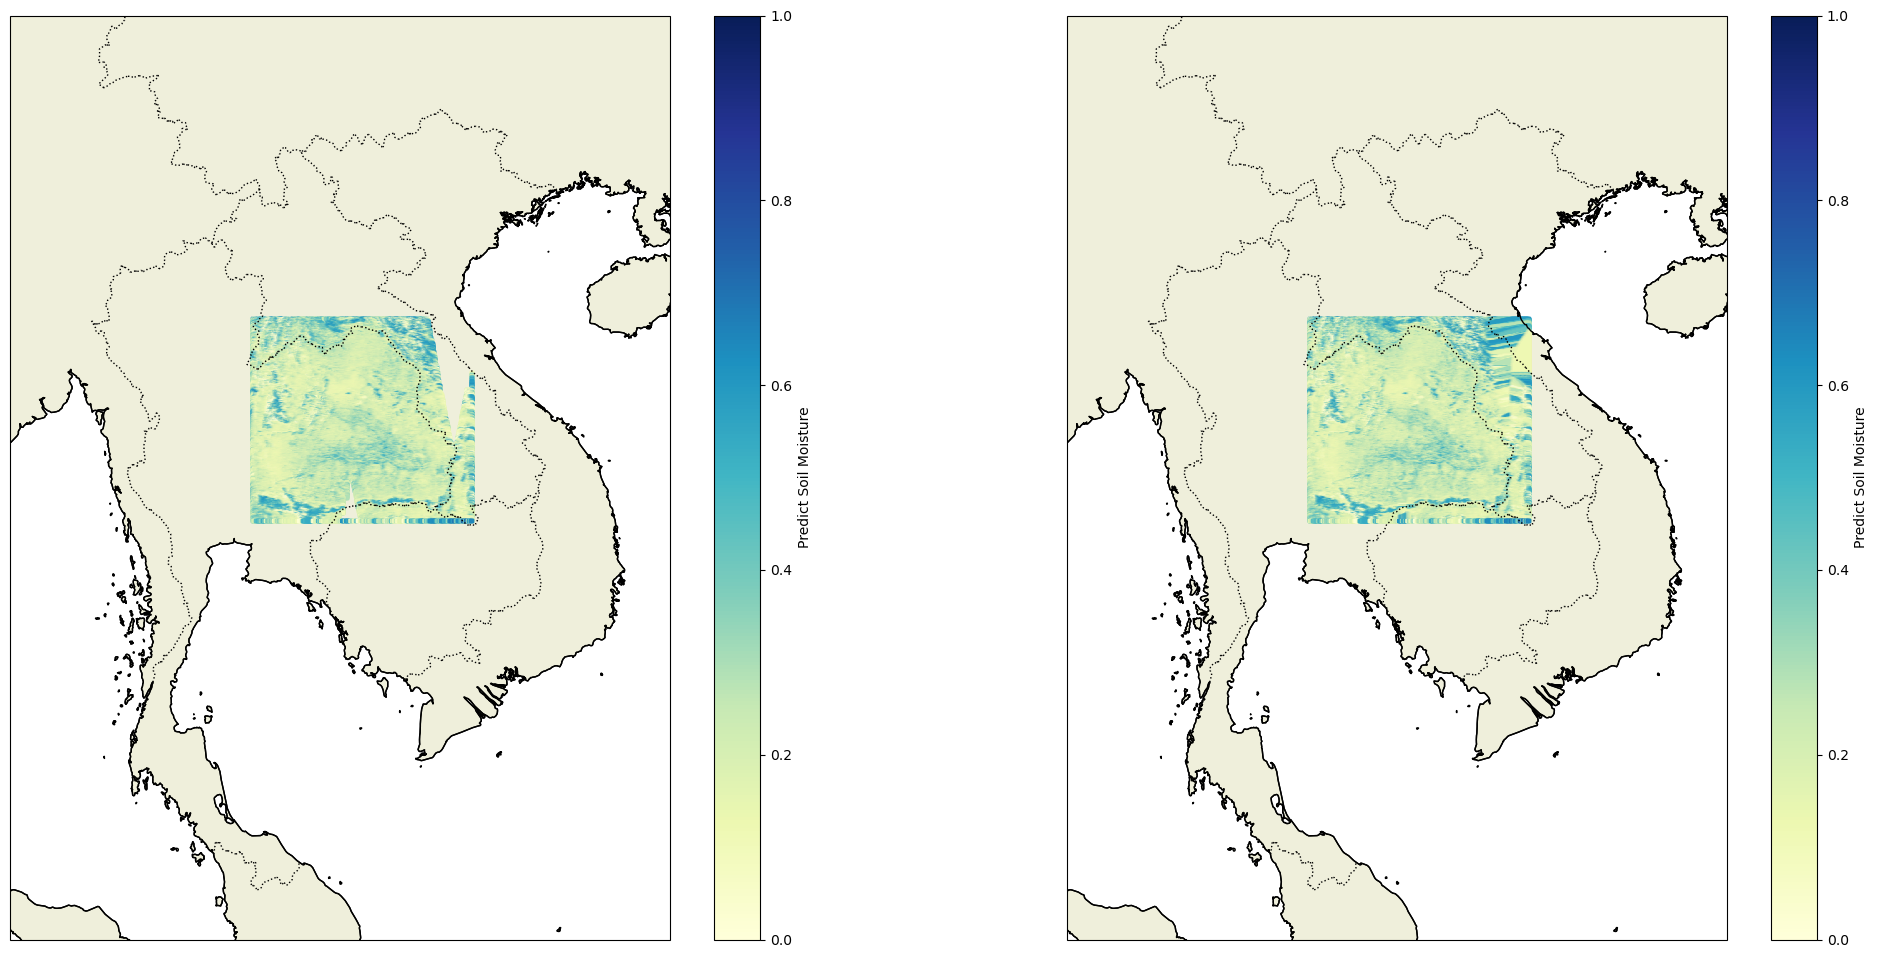

In [11]:

region_bounds = [4.5, 25.5, 95.5, 110.5]

# Create the figure and axis
projection = ccrs.PlateCarree()
fig, axes = plt.subplots(1,2, figsize=(25, 12), subplot_kw={'projection': projection})
ax1, ax2 = axes.flatten()

# Set the map extent to Thailand
min_lat, max_lat, min_lon, max_lon = region_bounds

# Original Data
ax1.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)
ax1.add_feature(cfeature.LAND, edgecolor='black')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')

#sc = ax.scatter(test_dfs[0]['longitude'], test_dfs[0]['latitude'], c=test_dfs[0]['val'], cmap='YlGnBu', marker='s', s=5, vmin=0, vmax=1, transform=projection)
sc1 = ax1.scatter(smapDf['longitude'], smapDf['latitude'], c=smapDf['val'], cmap='YlGnBu', marker='s', s=5, vmin=0, vmax=1, transform=projection)
#sc1 = ax1.scatter(smapDf['longitude'], smapDf['latitude'], c=smapDf['val'], cmap='YlGnBu', marker='s', s=5, transform=projection)
plt.colorbar(sc1, ax=ax1, orientation='vertical', label='Predict Soil Moisture')
# Add a title
ax2.set_title('', fontsize=14)

# Imputed data
ax2.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)
ax2.add_feature(cfeature.LAND, edgecolor='black')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')

#sc = ax.scatter(test_dfs[0]['longitude'], test_dfs[0]['latitude'], c=test_dfs[0]['val'], cmap='YlGnBu', marker='s', s=5, vmin=0, vmax=1, transform=projection)
sc2 = ax2.scatter(df_imputed['longitude'], df_imputed['latitude'], c=df_imputed['val'], cmap='YlGnBu', marker='s', s=5, vmin=0, vmax=1, transform=projection)
#sc2 = ax2.scatter(df_imputed['longitude'], df_imputed['latitude'], c=df_imputed['val'], cmap='YlGnBu', marker='s', s=5, transform=projection)
plt.colorbar(sc2, ax=ax2, orientation='vertical', label='Predict Soil Moisture')
# Add a title
ax2.set_title('', fontsize=14)

# Show the plot
plt.show()


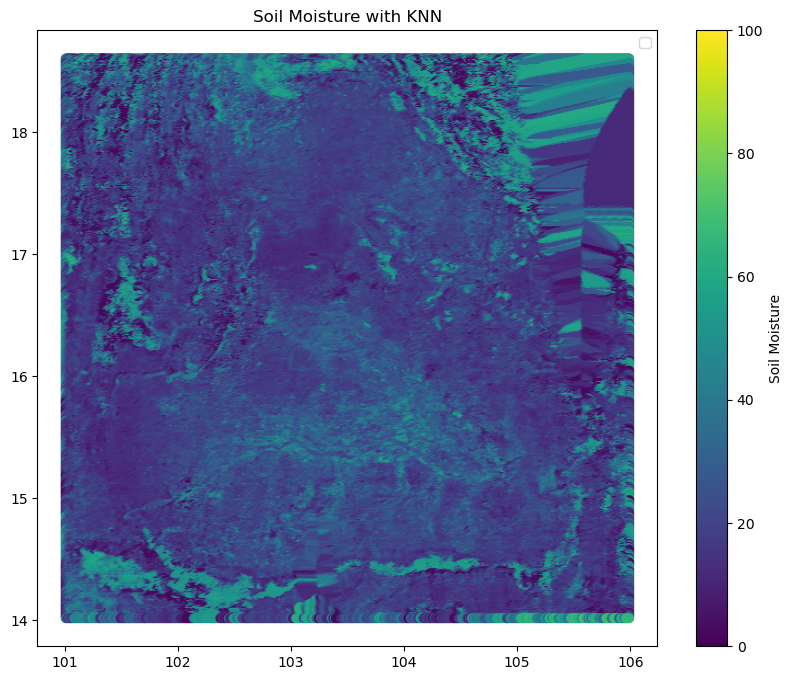

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(df_imputed['longitude'], df_imputed['latitude'], c=df_imputed['val']*100, cmap='viridis', vmin=0, vmax=100)
plt.colorbar(label='Soil Moisture')
plt.title('Soil Moisture with KNN')
plt.legend()
plt.savefig(f"./Img/KNN_Impute_with_2nn.png", dpi=300, bbox_inches='tight')
plt.show()